In [1]:
import torch

from torchfem import Truss

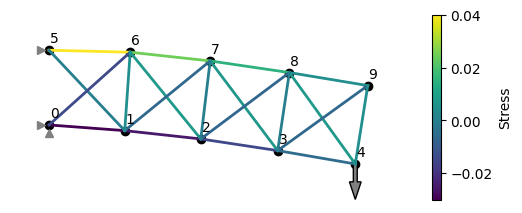

In [2]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.01
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
displacements = torch.zeros_like(nodes)
areas = torch.ones((len(elements)))
moduli = torch.ones((len(elements)))

truss_sample = Truss(nodes, elements, forces, displacements, constraints, areas, moduli)
u, f = truss_sample.solve()
sigma = truss_sample.compute_stress(u)
truss_sample.plot(u=u, sigma=sigma)

In [3]:
nodes = torch.tensor(
    [[-1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
)


elements = torch.tensor([[0, 3], [1, 3], [2, 3]])


forces = torch.zeros_like(nodes)
forces[3, 1] = -0.001
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0:3, :] = True
displacements = torch.zeros_like(nodes)
areas = 0.05 * torch.ones((len(elements)))
moduli = torch.ones((len(elements)))

truss3d = Truss(nodes, elements, forces, displacements, constraints, areas, moduli)
u, f = truss3d.solve()
sigma = truss3d.compute_stress(u)
truss3d.plot(u=u, sigma=sigma)

Widget(value="<iframe src='http://localhost:63587/index.html?ui=P_0x168f151b0_0&reconnect=auto' style='width: …